## Aditya Jindal
## Batch M6
## Assignment 7B
## _Efficient Neural Architecture Search discovered network_

In [1]:
# Importing all the required libraries from the modules

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, GlobalMaxPooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import *
from keras.utils import np_utils

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k
k.set_image_data_format('channels_last')

# Don't pre-allocate memory; allocate as-needed
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.visible_device_list = "0"
# Create a session with the above options specified.
set_session(tf.Session(config=config))

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)


Using TensorFlow backend.


In [2]:
# Loading a database and getting unique number of classes
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

print(num_classes)
print(train_features.shape)
print(test_features.shape)

170500096/170498071 [==============================] - 2s 0us/step
10
(50000, 32, 32, 3)
(10000, 32, 32, 3)


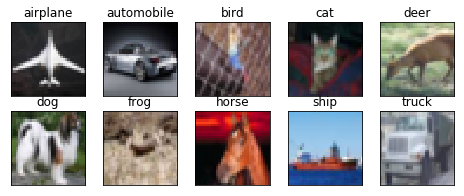

In [3]:
# Printing mentioned classes samples
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Defining function to plot loss and accuracy for model
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to get accuracy on our test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Set/Convert all the pixel values to float data type 
# Normalizing all pixel values by dividing with 255 so that every value lies btw 0-1

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Converted the above 1-dimensional class label arrays to num_classes-dimensional class matrices
# As the test and train labels are not splitted into num_classes distinct labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#SpaceToDepthFunction
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [9]:
# Defining a model using Functional API of Keras
# Import library for functional API
from keras.models import Model
from keras.layers import Input
from keras.regularizers import l2

# Declaring regulariser value
kernel_l2 = 1e-5

input = Input(shape=(32,32,3))

L1 = SeparableConv2D(32,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(input)
# Input for Layer 1 = (32x32x3)
# RF = 5
B1 = BatchNormalization()(L1)
D1 = Dropout(0.05)(B1)

L2 = Conv2D(64,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(D1)
# Input for Layer 2 = (32x32x32)
# RF = 9
B2 = BatchNormalization()(L2)
D2 = Dropout(0.05)(B2)

L3 = Conv2D(128,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(D2)
# Input for Layer 3 = (32x32x64)
# RF = 13
B3 = BatchNormalization()(L3)
D3 = Dropout(0.05)(B3)

Concat_1 = Concatenate(axis=-1)([D3, D1])

ConcatPoint1 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_1)
# Input for BottleNeck Layer 1 = (32x32x160)
# RF = 13
BCP1 = BatchNormalization()(ConcatPoint1)

L4 = SeparableConv2D(64,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP1)
# Input for Layer 4 = (32x32x32)
# RF = 17
B4 = BatchNormalization()(L4)
D4 = Dropout(0.05)(B4)

Concat_2 = Concatenate(axis=-1)([D4, D1])

ConvPoint1 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_2)
# Input for BottleNeck Layer 2 = (32x32x96)
# RF = 17

MPL1 = MaxPooling2D(pool_size=(2, 2))(ConvPoint1)
# Input for BottleNeck Layer 2 = (32x32x32)
# RF = 34

L5 = SeparableConv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(MPL1)
# Input for Layer 5 = (16x16x32)
# RF = 36
B5 = BatchNormalization()(L5)
D5 = Dropout(0.05)(B5)

DimBlock1 = Lambda(space_to_depth_x2)(D1)
DimBlock2 = Lambda(space_to_depth_x2)(D4)

Concat_3 = Concatenate(axis=-1)([D5, DimBlock1, DimBlock2])

ConcatPoint2 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_3)
# Input for BottleNeck Layer 3 = (16x16x448)
# RF = 36
BCP2 = BatchNormalization()(ConcatPoint2)

L6 = Conv2D(128,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP2)
# Input for Layer 6 = (16x16x64)
# RF = 40
B6 = BatchNormalization()(L6)
D6 = Dropout(0.05)(B6)

DimBlock3 = Lambda(space_to_depth_x2)(D3)

Concat_4 = Concatenate(axis=-1)([D6, DimBlock3, DimBlock2, D5])

ConcatPoint3 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_4)
# Input for BottleNeck Layer 4 = (16x16x960)
# RF = 40
BCP3 = BatchNormalization()(ConcatPoint3)

L7 = SeparableConv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP3)
# Input for Layer 7 = (16x16x64)
# RF = 42
B7 = BatchNormalization()(L7)
D7 = Dropout(0.05)(B7)

Concat_5 = Concatenate(axis=-1)([D7, D6, D5, DimBlock1, DimBlock2, DimBlock3])

ConcatPoint4 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_5)
# Input for BottleNeck Layer 5 = (16x16x1152)
# RF = 42
BCP4 = BatchNormalization()(ConcatPoint4)

L8 = SeparableConv2D(64,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP4)
# Input for Layer 8 = (16x16x64)
# RF = 46
B8 = BatchNormalization()(L8)
D8 = Dropout(0.05)(B8)

Concat_6 = Concatenate(axis=-1)([D8, DimBlock1, DimBlock2, D5, D7])

ConvPoint2 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_6)
# Input for BottleNeck Layer 6 = (16x16x576)
# RF = 46

MPL2 = MaxPooling2D(pool_size=(2, 2))(ConvPoint2)
# Input for BottleNeck Layer 6 = (16x16x64)
# RF = 92

DimBlock4 = Lambda(space_to_depth_x2)(D6)

Concat_7 = Concatenate(axis=-1)([MPL2, DimBlock4])

ConcatPoint5 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_7)
# Input for BottleNeck Layer 7 = (8x8x576)
# RF = 92
BCP5 = BatchNormalization()(ConcatPoint5)

L9 = Conv2D(64,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP5)
# Input for Layer 9 = (8x8x64)
# RF = 96
B9 = BatchNormalization()(L9)
D9 = Dropout(0.05)(B9)

DimBlock5 = Lambda(space_to_depth_x2)(DimBlock2)
DimBlock6 = Lambda(space_to_depth_x2)(D7)
DimBlock7 = Lambda(space_to_depth_x2)(D2)
DimBlock8 = Lambda(space_to_depth_x2)(DimBlock7)

Concat_8 = Concatenate(axis=-1)([D9, DimBlock5, DimBlock6, DimBlock8])

ConcatPoint6 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_8)
# Input for BottleNeck Layer 8 = (8x8x2368)
# RF = 96
BCP6 = BatchNormalization()(ConcatPoint6)

L10 = SeparableConv2D(128,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP6)
# Input for Layer 10 = (8x8x64)
# RF = 100
B10 = BatchNormalization()(L10)
D10 = Dropout(0.05)(B10)

DimBlock9 = Lambda(space_to_depth_x2)(D5)
DimBlock10 = Lambda(space_to_depth_x2)(DimBlock3)

Concat_9 = Concatenate(axis=-1)([D10, D9, DimBlock9, DimBlock10, DimBlock8])

ConcatPoint7 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_9)
# Input for BottleNeck Layer 9 = (8x8x3520)
# RF = 100
BCP7 = BatchNormalization()(ConcatPoint7)

L11 = Conv2D(128,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP7)
# Input for Layer 11 = (8x8x64)
# RF = 102
B11 = BatchNormalization()(L11)
D11 = Dropout(0.05)(B11)

DimBlock11 = Lambda(space_to_depth_x2)(DimBlock1)

Concat_10 = Concatenate(axis=-1)([D11, D10, DimBlock5, DimBlock6, DimBlock11, DimBlock9, DimBlock10])

ConcatPoint8 = Conv2D(64,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_10)
# Input for BottleNeck Layer 10 = (8x8x4352)
# RF = 102
BCP8 = BatchNormalization()(ConcatPoint8)

L12 = SeparableConv2D(64,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BCP8)
# Input for Layer 12 = (8x8x64)
# RF = 106
B12 = BatchNormalization()(L12)
D12 = Dropout(0.05)(B12)

Concat_11 = Concatenate(axis=-1)([D12, D10, DimBlock5, DimBlock6])

ConcatPoint9 = Conv2D(10,(1, 1), kernel_regularizer=l2(kernel_l2), padding='same')(Concat_11)
# Input for BottleNeck Layer 11 = (8x8x1472)
# RF = 106

GAPL = GlobalMaxPooling2D()(ConcatPoint9)
# Input for Layer 1 = (8x8x10)

output = Activation('softmax')(GAPL)
# Input for Out Layer = (,10)

#Initialising the Model
model_tuned = Model(inputs=[input], outputs=[output])
model_tuned.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 32, 32, 32)   203         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 32, 32)   128         separable_conv2d_8[0][0]         
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_17 

In [10]:
# Compile the model
model_tuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Changing Learning rate based on monitored quantity
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=1, 
             mode='max', min_delta=0.001, min_lr=0.00001)


W0616 12:22:25.062684 140545251043200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



W0616 12:22:44.782218 140545251043200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 82s 2ms/step - loss: 1.7261 - acc: 0.3741 - val_loss: 1.6848 - val_acc: 0.4652
Epoch 2/100
50000/50000 [==============================] - 68s 1ms/step - loss: 1.2557 - acc: 0.5547 - val_loss: 1.2009 - val_acc: 0.5826
Epoch 3/100
50000/50000 [==============================] - 67s 1ms/step - loss: 0.9849 - acc: 0.6580 - val_loss: 1.0596 - val_acc: 0.6460
Epoch 4/100
50000/50000 [==============================] - 68s 1ms/step - loss: 0.8183 - acc: 0.7175 - val_loss: 1.0233 - val_acc: 0.6548
Epoch 5/100
50000/50000 [==============================] - 68s 1ms/step - loss: 0.6926 - acc: 0.7671 - val_loss: 0.8896 - val_acc: 0.7123
Epoch 6/100
50000/50000 [==============================] - 68s 1ms/step - loss: 0.5906 - acc: 0.8018 - val_loss: 0.7655 - val_acc: 0.7518
Epoch 7/100
50000/50000 [==============================] - 67s 1ms/step - loss: 0.4939 - acc: 0.8363 - val_loss: 1.0168 - 

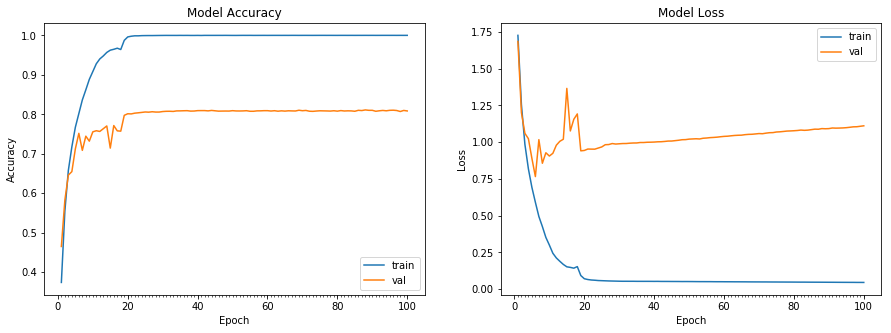

Accuracy on test data is: 80.85 


In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Image Normalization
# datagen_train = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# datagen_train.fit(train_features)

# datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# datagen_test.fit(test_features)

# Train the model
start = time.time()
# model_info_tuned = model_tuned.fit_generator(datagen_train.flow(train_features, train_labels, batch_size = 128),
#                                  steps_per_epoch = train_features.shape[0]//128, epochs = 100,
#                                  validation_data = datagen_test.flow(test_features, test_labels, batch_size = 128),
#                                  validation_steps = test_features.shape[0]//128,
#                                  verbose=1, callbacks = [reduce_lr])
model_info_tuned = model_tuned.fit(train_features, train_labels, batch_size = 256,
                                 epochs = 100, validation_data = (test_features, test_labels),
                                 verbose=1, callbacks = [reduce_lr])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info_tuned)
# compute test accuracy
print ("Accuracy on test data is: %0.2f "%accuracy(test_features, test_labels, model_tuned))

## Test Accuracy
### Achieved 80.85 at the 100th epoch
### Max achieved 81.11 at the 88th epoch

